In [3]:
%matplotlib inline

import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cmath
import math
import Image
from keras.datasets import mnist


def resize(input_im):
    im = Image.fromarray(input_im)
    im = im.resize([10,10], Image.ANTIALIAS)
    rz_im = np.asarray((im.getdata()))
    return np.reshape(rz_im, (10,10))

def getXsvd(imgmat,k):
    U, sigma, V = np.linalg.svd(imgmat)
    reconstimg = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
#     plt.imshow(reconstimg, cmap='gray')
    return reconstimg
    
def getX_10():    
    X_10_train = np.zeros((60000,10,10))
    X_10_test =  np.zeros((10000,10,10))
    (X_train, _), (X_test, _) = mnist.load_data()
    for i in range(X_train.shape[0]):
        X_10_train[i,:,:] = resize(X_train[i])
    for i in range(X_test.shape[0]):
        X_10_test[i,:,:] = resize(X_test[i])
    return X_10_train,X_10_test

# Playing with last layer (only Dense10)

In [5]:
from __future__ import print_function
import numpy as np
import random
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2, activity_l2


batch_size = 512
nb_classes = 10
nb_epoch = 256

train_slice = 1000
test_slice = 10000


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

X_train_10000 = X_train[:train_slice]
X_test_10000 = X_test[:test_slice]

print(X_train_10000.shape[0], 'train samples')
print(X_test_10000.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train[:train_slice], nb_classes)
Y_test = np_utils.to_categorical(y_test[:test_slice], nb_classes)

FC0 = Dense(512, input_shape=(784,))
FC1 = Dense(512)
FC2 = Dense(10)

model = Sequential()
model.add(FC0)
model.add(Activation('relu'))
model.add(FC1)
model.add(Activation('relu'))
model.add(FC2)
model.add(Activation('softmax'))

model.summary()

model.compile(loss='mse',
              optimizer='adadelta',
              metrics=['accuracy'])

history = model.fit(X_train_10000, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test_10000, Y_test))
score = model.evaluate(X_test_10000, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
test_score = score[0]

score = model.evaluate(X_train_10000, Y_train, verbose=0)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1000 train samples
10000 test samples
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           401920      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           262656      activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 512)           0           dense_2[0][0]                    
_____________________________________________________

# Trying to figure out the proper value for incrementing weight
 - run another epoch, get the mode of weight difference

In [6]:
layers_weights = [model.layers[0].get_weights(), model.layers[2].get_weights(),model.layers[4].get_weights()]

# for backup purpose if we did something wrong, we can get the weight right here, no need to train the whole network
orignial_layers_weight = np.copy(layers_weights)

# for altering purpose make changes then put back into the network
layer_4_altered_weight = np.copy(layers_weights[2])

# to keep track of rate of change wrt the loss and weight
l_wrt_w = np.zeros(layers_weights[2][0].shape + (2,))

print(l_wrt_w.shape)

(512, 10, 2)


In [7]:
history = model.fit(X_train_10000, Y_train,
                    batch_size=batch_size, nb_epoch=1,
                    verbose=0, validation_data=(X_test_10000, Y_test))

In [36]:
# get mode of weight differences
l4w = model.layers[4].get_weights()
d = (l4w[0] - layers_weights[2][0])

from collections import Counter
data = Counter(d.flatten())
mode_w = data.most_common(10000)  # Returns the highest occurring item

In [49]:
num = 1*10**-4
print(num)

0.0001


In [69]:
res = mode_w[0]
print(res[0])

0.0


In [74]:
print([10**(x) for x in range(30)])

[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000, 10000000000000, 100000000000000, 1000000000000000, 10000000000000000, 100000000000000000, 1000000000000000000, 10000000000000000000L, 100000000000000000000L, 1000000000000000000000L, 10000000000000000000000L, 100000000000000000000000L, 1000000000000000000000000L, 10000000000000000000000000L, 100000000000000000000000000L, 1000000000000000000000000000L, 10000000000000000000000000000L, 100000000000000000000000000000L]


# Iterate to find the most mainstream number

In [88]:
print(mode_w[1000])

(-7.2531402e-06, 1)


In [108]:
dic = {}

for num in mode_w:
    for j in [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000, 10000000000000, 100000000000000, 1000000000000000, 10000000000000000, 100000000000000000, 1000000000000000000, 10000000000000000000L, 100000000000000000000L, 1000000000000000000000L, 10000000000000000000000L, 100000000000000000000000L, 1000000000000000000000000L, 10000000000000000000000000L, 100000000000000000000000000L, 1000000000000000000000000000L, 10000000000000000000000000000L, 100000000000000000000000000000L]:
        res = abs(num[0] * j)
#         print(res)
        if res >= 1 and res < 10:
            dic[j] = dic.get(j,0)+1

In [111]:
print(dic)
for k,v in dic.iteritems():
    print(1.0/k, v)

{1000000000: 14, 100000000: 51, 10000: 177, 1000000: 975, 10000000: 224, 100000: 3133}
1e-09 14
1e-08 51
0.0001 177
1e-06 975
1e-07 224
1e-05 3133


In [ ]:
model.layers[0].set_weights(layers_weights[0])
model.layers[2].set_weights(layers_weights[1])


for idx in [0,2,4]:
    model.layers[idx].trainable = False

for i in range(l_wrt_w.shape[0]):
    for j in range(l_wrt_w.shape[1]):
        
        # keep the originial weight, so we don't need to do the math twice(*10, /10)
        weight_dummy = layer_4_altered_weight[0][i][j]
        
        # make it ten times much bigger or smaller, see how to changes the network
        layer_4_altered_weight[0][i][j] *= 10
        
        # set the weight to the network, and evaluate the score
        model.layers[4].set_weights(layer_4_altered_weight)
        score = model.evaluate(X_test_10000, Y_test, verbose=0)
        
        l_wrt_w[i][j][0] = test_score - score[0]
        l_wrt_w[i][j][1] = weight_dummy - layer_4_altered_weight[0][i][j]

        if (j%5 == 0):
            print("i,j = ", i, j)
        
        # set the weight back
        layer_4_altered_weight[0][i][j] = layers_weights[2][0][i][j]

What the fuck do we get from delta Loss/weight

(512, 10, 2)


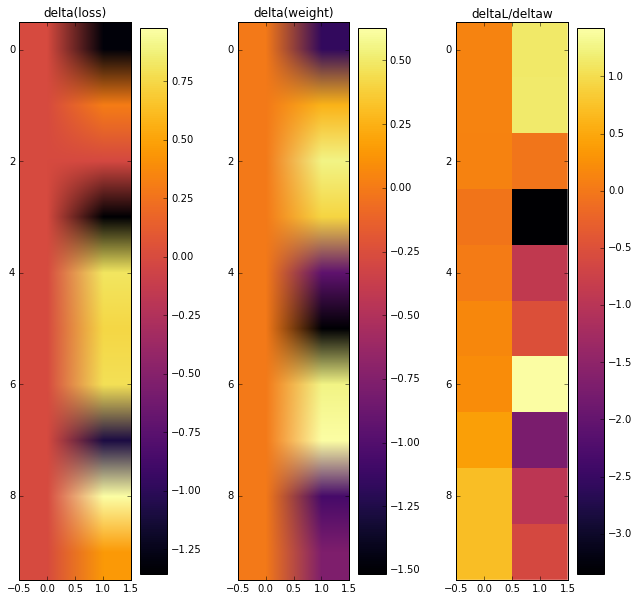

In [209]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
print(l_wrt_w.shape)

intp = 'None'

plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(l_wrt_w[:][:][:][0], cmap='inferno')#, interpolation=intp)
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(142)
plt.imshow(l_wrt_w[:][:][:][1], cmap='inferno')#, interpolation=intp)
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(143)
plt.imshow(l_wrt_w[:][:][:][0]/l_wrt_w[:][:][:][1], cmap='inferno', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

# plt.subplot(144)
# plt.imshow(l_wrt_w[:][:][:][0]/abs(l_wrt_w[:][:][:][1]), cmap='inferno')#, interpolation=intp)
# plt.title('deltaL/abs(w)')
# plt.colorbar()

# plt.subplot(155)
# plt.imshow(abs(l_wrt_w[:][:][:][0])/abs(l_wrt_w[:][:][:][1]), cmap='inferno')#, interpolation=intp)
# plt.title('abs(deltaL)/abs(w)')

# plt.colorbar()

In [167]:
import pickle

with open('l_wrt_w_lastlayer_9888', 'wb') as handle:
    pickle.dump(l_wrt_w, handle)

# pf = open('l_wrt_w_lastlayer_9888','rb')
# l_wrt_w = pickle.load(pf)

In [212]:
w_diff = []
for o,n in zip(layers_weights[2],model.layers[4].get_weights()):
    w_diff.append(abs(o-n))

In [215]:
from collections import Counter
data = Counter(w_diff)
data.most_common()   # Returns all unique items and their counts
data.most_common(1)  # Returns the highest occurring item

TypeError: unhashable type: 'numpy.ndarray'